In [160]:
import pandas as pd
dataset = pd.read_csv(r'C:\Users\mtsil\Desktop\german_essays.csv', encoding='unicode_escape')

In [161]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset.head(2)

,rater,thema,i_1,i_2,i_3,i_4,t_1,t_2,t_3,sr_1,sr_2,sr_3,sr_4,sa_1,sa_2,sa_3,sa_4,id_text,wle_dsch,sewle_dsch,punkte_dsch,sumscore,essay
0,9,1,2,2,1,1,0,2,1,2,1,2,2,2,2,1,2,K011_001,0.450426,0.551269,822.0,23,"Ich möchte gern in Spanien wohnen, am besten i..."
1,9,1,2,2,1,2,1,2,2,2,1,3,2,2,2,1,2,K011_002,1.651275,0.553108,916.0,27,Ich würde gerne in einem Haus leben. Es sollte...


In [162]:
# create df1 to store the essay variable

df1 = dataset['essay']

In [163]:
# add the values of the holistic criterion across each row; the sum score is stored in the df2 pandas data frame

pd.set_option('display.max_rows', None)
df2 = dataset[['i_3', 'i_4', 't_1', 't_2', 't_3', 'sr_1', 'sr_2', 'sr_3', 'sr_4', 'sa_1', 'sa_2', 'sa_3', 'sa_4']].agg(['sum'], axis=1)
df2.head(2)

,sum
0,19
1,23


In [164]:
# concatenate df1 and df2 into a new pandas data frame called holistic
# the last three rows do not contain any values for the essay variable

holistic = pd.concat([df1, df2], axis=1)
holistic.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",19
1,Ich würde gerne in einem Haus leben. Es sollte...,23


In [165]:
# drop the last three rows and create the final pandas data frame called final_holistic

final_holistic = holistic.drop([125, 126, 127])
final_holistic.shape

(125, 2)

In [166]:
# check the distribution of the values for the holistic criterion

final_holistic[['sum']].value_counts()

sum
21     11
25     10
20     10
23      9
13      9
18      8
22      8
14      8
24      7
26      7
19      6
16      6
17      5
15      5
10      4
9       3
27      2
28      2
12      2
11      2
4       1
Name: count, dtype: int64

In [167]:
from sklearn.preprocessing import KBinsDiscretizer

# Quantile Discretization

quantile_discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
final_holistic['sum'] = quantile_discretizer.fit_transform(final_holistic[['sum']])

final_holistic.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",1.0
1,Ich würde gerne in einem Haus leben. Es sollte...,3.0


In [168]:
final_holistic['sum'] = final_holistic['sum'].astype(int)
final_holistic.head(2)

,essay,sum
0,"Ich möchte gern in Spanien wohnen, am besten i...",1
1,Ich würde gerne in einem Haus leben. Es sollte...,3


In [169]:
final_holistic['sum'].value_counts(ascending = True)

sum
2    29
0    29
1    30
3    37
Name: count, dtype: int64

In [170]:
X = final_holistic['essay']
y = final_holistic['sum']

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 6000)
X = td.fit_transform(X).toarray()

In [172]:
# no need for the parameter test_size becauseone-third of the data it is set aside as test data, known as the out-of-bag (oob) sample 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     random_state=0, 
                                                    shuffle=True)

In [173]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.0108695652173914,
 1: 0.8942307692307693,
 2: 1.2916666666666667,
 3: 0.8942307692307693}

In [174]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 150, class_weight= class_weights, min_samples_split = 20, min_samples_leaf = 30, random_state=42, n_jobs=-1)
model.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1.0108695652173914,
                                     1: 0.8942307692307693,
                                     2: 1.2916666666666667,
                                     3: 0.8942307692307693},
                       min_samples_leaf=30, min_samples_split=20,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [175]:
predictions = model.predict(X_test)

In [176]:
from sklearn.metrics import accuracy_score

In [177]:
print(f'Training set accuracy: {model.score(X_train, y_train):.4f}')
print(f'Test set accuracy: {model.score(X_test, y_test):.4f}')

Training set accuracy: 0.5054
Test set accuracy: 0.3438


In [178]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.14      0.25      0.18         4
           2       0.29      0.18      0.22        11
           3       0.47      0.64      0.54        11

    accuracy                           0.34        32
   macro avg       0.31      0.31      0.29        32
weighted avg       0.34      0.34      0.33        32



In [179]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,predictions)

<Axes: >

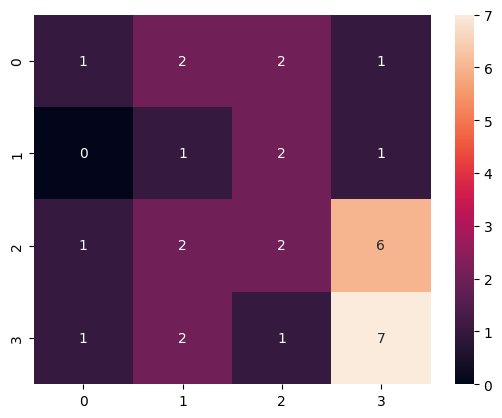

In [180]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='.2g')

In [181]:
from sklearn.metrics import roc_auc_score


y_preb_probs = model.predict_proba(X_test)

roc_auc_score(y_test, y_preb_probs, average="weighted", multi_class="ovr")

0.5472470238095238

In [182]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, predictions)

0.08695652173913049

In [183]:
import joblib 


filename = 'joblib_model.sav'
joblib.dump(model, filename)

['joblib_model.sav']

In [184]:
loaded_model = joblib.load(filename)

In [185]:
loaded_model

RandomForestClassifier(class_weight={0: 1.0108695652173914,
                                     1: 0.8942307692307693,
                                     2: 1.2916666666666667,
                                     3: 0.8942307692307693},
                       min_samples_leaf=30, min_samples_split=20,
                       n_estimators=150, n_jobs=-1, random_state=42)

In [186]:
y_predict = model.predict(X_test)

In [187]:
print(classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.14      0.25      0.18         4
           2       0.29      0.18      0.22        11
           3       0.47      0.64      0.54        11

    accuracy                           0.34        32
   macro avg       0.31      0.31      0.29        32
weighted avg       0.34      0.34      0.33        32

